## 📥 Import libraries

In [139]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import getpass
import matplotlib.pyplot as plt
from masks_S5 import masks
from masks_S2 import masks_S2
from masks_S3 import masks_S3
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

import os
from dotenv import load_dotenv
import numpy as np

load_dotenv()

True

Il faut se créer des OAuth sur https://shapps.dataspace.copernicus.eu/dashboard/#/ -> User settings -> en dessous de "OAuth clients" -> "Create" puis mettre un nom et copier ça dans un .env :

`SENTINEL_HUB_CLIENT_ID="esqfqesfqesffe-esffesqfes-fesqqefsqfes"`

`SENTINEL_HUB_CLIENT_SECRET="sjibiqb"`

In [140]:
config = SHConfig()
config.sh_client_id = os.getenv("SENTINEL_HUB_CLIENT_ID") or getpass.getpass("Enter your Sentinel Hub client ID: ")
config.sh_client_secret = os.getenv("SENTINEL_HUB_CLIENT_SECRET") or getpass.getpass("Enter your Sentinel Hub client secret: ")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

config.save("takeair")

## ⌨️ User Input

Si on veut faire une request sur une bbox définie (http://bboxfinder.com)

In [141]:
center_coordinates = [7.736971, 48.523071]  # Longitude, Latitude
range_km = 100                               # Radius in kilometers
resolution_m = 300                          # Resolution in meters


Visualisation de tous les satellites disponibles : 

In [142]:
from sentinelhub import DataCollection

satellites = {}
for collection in DataCollection:
    try:
        satellites[collection.name] = [band.name for band in collection.bands]
    except:
        satellites[collection.name] = []

for satellite, bands in satellites.items():
    print(f"\n{satellite}:")
    if bands:
        for band in bands:
            print(f"- {band}")
    else:
        print("No bands available")



SENTINEL2_L1C:
- B01
- B02
- B03
- B04
- B05
- B06
- B07
- B08
- B8A
- B09
- B10
- B11
- B12

SENTINEL2_L2A:
- B01
- B02
- B03
- B04
- B05
- B06
- B07
- B08
- B8A
- B09
- B11
- B12

SENTINEL1:
No bands available

SENTINEL1_IW:
- VV
- VH

SENTINEL1_IW_ASC:
- VV
- VH

SENTINEL1_IW_DES:
- VV
- VH

SENTINEL1_EW:
- HH
- HV

SENTINEL1_EW_ASC:
- HH
- HV

SENTINEL1_EW_DES:
- HH
- HV

SENTINEL1_EW_SH:
- HH

SENTINEL1_EW_SH_ASC:
- HH

SENTINEL1_EW_SH_DES:
- HH

DEM:
- DEM

DEM_MAPZEN:
- DEM

DEM_COPERNICUS_30:
- DEM

DEM_COPERNICUS_90:
- DEM

MODIS:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_MSS_L1:
- B01
- B02
- B03
- B04

LANDSAT_TM_L1:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_TM_L2:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_ETM_L1:
- B01
- B02
- B03
- B04
- B05
- B06_VCID_1
- B06_VCID_2
- B07
- B08

LANDSAT_ETM_L2:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_OT_L1:
- B01
- B02
- B03
- B04
- B05
- B06
- B07
- B08
- B09
- B10
- B11

LANDSAT_OT_L2:
- B01
- B02


Simple affichage de tous les satellites disponibles :

In [143]:
for satellite in satellites:
    print(f"{satellite}")

SENTINEL2_L1C
SENTINEL2_L2A
SENTINEL1
SENTINEL1_IW
SENTINEL1_IW_ASC
SENTINEL1_IW_DES
SENTINEL1_EW
SENTINEL1_EW_ASC
SENTINEL1_EW_DES
SENTINEL1_EW_SH
SENTINEL1_EW_SH_ASC
SENTINEL1_EW_SH_DES
DEM
DEM_MAPZEN
DEM_COPERNICUS_30
DEM_COPERNICUS_90
MODIS
LANDSAT_MSS_L1
LANDSAT_TM_L1
LANDSAT_TM_L2
LANDSAT_ETM_L1
LANDSAT_ETM_L2
LANDSAT_OT_L1
LANDSAT_OT_L2
SENTINEL5P
SENTINEL3_OLCI
SENTINEL3_SLSTR
HARMONIZED_LANDSAT_SENTINEL
s5p
s2l2a
s3slstr


In [144]:
satellites['SENTINEL5P']

['CO',
 'HCHO',
 'NO2',
 'O3',
 'SO2',
 'CH4',
 'AER_AI_340_380',
 'AER_AI_354_388',
 'CLOUD_BASE_PRESSURE',
 'CLOUD_TOP_PRESSURE',
 'CLOUD_BASE_HEIGHT',
 'CLOUD_TOP_HEIGHT',
 'CLOUD_OPTICAL_THICKNESS',
 'CLOUD_FRACTION']

## 🛸 Sentinel - Request

In [145]:
def request_S2(bbox, mask, resolution=(1481, 1538)):
    request = SentinelHubRequest(
        evalscript=mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(name='s2l2a', service_url='https://sh.dataspace.copernicus.eu'),          
                time_interval=('2025-04-17', '2025-05-17'),          
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.JPG),
        ],
        bbox=bbox,
        size=resolution,
        config=config
    )
    response = request.get_data()
    return response[0]

In [146]:
def request_SENTINEL3_SLSTR(bbox, mask, resolution):
    request = SentinelHubRequest(
        evalscript=mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL3_SLSTR.define_from(name='s3slstr', service_url='https://sh.dataspace.copernicus.eu'),
                time_interval=("2023-05-16", "2025-05-16"),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.JPG),
        ],
        bbox=bbox,
        size=resolution,
        config=config
    )
    response = request.get_data()
    return response[0]


## 👉 Here UV is missing

In [147]:
def request_S5P(bbox_par, mask, resolution):
    data_5p = DataCollection.SENTINEL5P.define_from("s5p", service_url=config.sh_base_url)

    request_raw = SentinelHubRequest(
        evalscript=mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_5p,
                time_interval=("2023-05-16", "2025-05-16"),
            )
        ],
        responses=[SentinelHubRequest.output_response("index", MimeType.TIFF)],
        bbox=bbox_par,
        # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
        # Since we have defined our bounding box in Web mercator the resolution is in meters.
        resolution=resolution,
        config=config,
        data_folder="./",  # We save the data in a specified folder
    )
    response = request_raw.get_data()
    return response[0]

### Environmental Mask Extraction

- Defines target Sentinel variables and their default values.
- `create_bbox`: creates a WGS84 bounding box, optionally converted to EPSG:3857.
- `calculate_masks`:
  - Builds a bounding box around a given (lon, lat) with a specified radius (km).
  - Fetches available masks using `request_S5P`.
  - Returns a DataFrame with (x, y) coordinates and variable values.


In [148]:
from shapely.geometry import box
from pyproj import Transformer
from skimage.transform import resize

variables = [
    'TEMPERATURE',# Temperature (SENTINEL-3)
    'NDVI',       # Vegetation Index (SENTINEL-2)
    'CO',         # Carbon Monoxide (SENTINEL-5P)
    'HCHO',       # Formaldehyde (SENTINEL-5P)
    'NO2',        # Nitrogen Dioxide (SENTINEL-5P)
    'O3',         # Ozone (SENTINEL-5P)
    'SO2',        # Sulfur Dioxide (SENTINEL-5P)
    'CH4',        # Methane (SENTINEL-5P)
    'AER_AI'      # Aerosol Index (SENTINEL-5P)
]

DEFAULT_VALUES = {
    "NO2": 2e-5,
    "AER_AI": 0.0,
    "O3": 0.1,
    "CO": 0.01,
    "SO2": 1e-5,
    "HCHO": 2e-4,
    "CH4": 1800.0,
    "NDVI": 0.5,
    "TEMPERATURE": 293.15
}

def create_bbox(coords, transform_to_3857=True):
    bbox = BBox(bbox=coords, crs=CRS.WGS84)
    if transform_to_3857:
        return bbox.transform(CRS(3857))
    return bbox

def calculate_masks(person_coordinates, radius_kilometers, resolution=300):
    lon, lat = person_coordinates
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    x_center, y_center = transformer.transform(lon, lat)

    x_min = x_center - radius_kilometers * 1000
    x_max = x_center + radius_kilometers * 1000
    y_min = y_center - radius_kilometers * 1000
    y_max = y_center + radius_kilometers * 1000

    bbox_3857 = BBox(bbox=[x_min, y_min, x_max, y_max], crs=CRS.POP_WEB)

    data = {}
    coords = []

    for mask_name, mask_script in masks.items():
        if mask_name == "UV":
            continue
        if mask_name not in variables:
            continue
        print(f"Requesting mask: {mask_name}")
        response = request_S5P(
            bbox_par=bbox_3857,
            mask=mask_script,
            resolution=bbox_to_dimensions(bbox_3857, resolution)
        )
        # response is a 2D array, store it in the dict
        data[mask_name] = response
        print(f"Response shape for {mask_name}: {response.shape}")
        # Save coordinates only once
        if not coords:
            # Generate grid of coordinates for each pixel
            x_vals = np.linspace(x_min, x_max, response.shape[1])
            y_vals = np.linspace(y_max, y_min, response.shape[0])  # y decreases from top to bottom
            coords = [(x, y) for y in y_vals for x in x_vals]

    # Flatten each mask's 2D array to 1D for DataFrame columns
    df_dict = {}
    for mask_name, arr in data.items():
        df_dict[mask_name] = arr.flatten()
    df = pd.DataFrame(df_dict)
    df['x'] = [c[0] for c in coords]
    df['y'] = [c[1] for c in coords]
    df = df[['x', 'y'] + [k for k in data.keys()]]  # order columns

    return bbox_3857, df

In [149]:
bbox, df = calculate_masks(center_coordinates, range_km, resolution)

Requesting mask: AER_AI


Response shape for AER_AI: (15, 15)
Requesting mask: CO
Response shape for CO: (15, 15)
Requesting mask: HCHO
Response shape for HCHO: (15, 15)
Requesting mask: NO2
Response shape for NO2: (15, 15)
Requesting mask: SO2
Response shape for SO2: (15, 15)


### Here we make requests on S2 and S3 in JPG and try transformations to obtain coherent normalized values

# 👉 Here the add of UV in the dataframe is missing

In [150]:
response_ndvi = request_S2(bbox, masks_S2['NDVI'], (467, 445))
response_temp = request_SENTINEL3_SLSTR(bbox, masks_S3['TEMPERATURE'], (1000, 1000))

# Convert NDVI from 0-255 to -1 to 1
ndvi_img_rescaled = response_ndvi.astype(np.float32) / 127.5 - 1

# Flatten and resize if needed
ndvi_flat = ndvi_img_rescaled.flatten()
if ndvi_flat.shape[0] != df.shape[0]:
    ndvi_flat = resize(ndvi_flat, (df.shape[0],), order=1, mode='reflect', anti_aliasing=True)

df['NDVI'] = ndvi_flat

# Flatten and resize temperature response if needed
temp_img = response_temp.astype(np.float32)
if np.all(temp_img == 0):
    # Fill with default temperature (Kelvin)
    temp_flat = np.full(df.shape[0], DEFAULT_VALUES['TEMPERATURE'], dtype=np.float32)
else:
    # If not all zeros, flatten and resize as needed
    temp_flat = temp_img.flatten()
    if temp_flat.shape[0] != df.shape[0]:
        temp_flat = resize(temp_flat, (df.shape[0],), order=1, mode='reflect', anti_aliasing=True)

df['TEMPERATURE'] = temp_flat


In [151]:
df.head(10)

,x,y,AER_AI,CO,HCHO,NO2,SO2,NDVI,TEMPERATURE
0,761275.672002,6.294321e+06,-1.412591,0.029932,-0.000058,0.000033,0.000031,-0.600200,293.149994
1,775561.386288,6.294321e+06,-1.289966,0.029800,-0.000112,NaN,0.000130,-0.653607,293.149994
2,789847.100574,6.294321e+06,-0.400635,NaN,NaN,NaN,NaN,-0.666408,293.149994
3,804132.814859,6.294321e+06,-0.487871,0.026511,NaN,NaN,NaN,-0.636694,293.149994
4,818418.529145,6.294321e+06,-1.876241,0.028353,0.000058,0.000025,-0.000255,-0.621238,293.149994
5,832704.243431,6.294321e+06,-1.527804,0.029479,0.000146,0.000032,0.000668,-0.639441,293.149994
6,846989.957717,6.294321e+06,-1.478700,0.030491,0.000105,0.000027,0.000165,-0.651735,293.149994
7,861275.672002,6.294321e+06,-0.353147,NaN,NaN,NaN,NaN,-0.632975,293.149994
8,875561.386288,6.294321e+06,-0.425219,0.029426,NaN,NaN,NaN,-0.644042,293.149994
9,889847.100574,6.294321e+06,-0.361587,NaN,NaN,NaN,NaN,-0.633419,293.149994


### We complete the completly NaN columns with default values and for the missing values we do a gradient with now values

In [152]:
def complete_df(df):
    # Complete the NaN values in columns using a gradient or default value
    for var in variables:
        if var not in df.columns:
            print(f"{var} missing, filling with default: {DEFAULT_VALUES[var]}")
            df[var] = DEFAULT_VALUES[var]
        else:
            if df[var].isnull().any():
                not_nan = df[var].dropna()
                if not_nan.empty:
                    df[var] = DEFAULT_VALUES[var]
                else:
                    min_val, max_val = not_nan.min(), not_nan.max()
                    # If all values are the same, fill with that value
                    if min_val == max_val:
                        df[var] = df[var].fillna(min_val)
                    else:
                        # Create a gradient for NaNs
                        nan_idx = df[var][df[var].isnull()].index
                        gradient = np.linspace(min_val, max_val, len(nan_idx))
                        df.loc[nan_idx, var] = gradient
    return df

In [153]:
complete_df(df)
df.head(10)

O3 missing, filling with default: 0.1
CH4 missing, filling with default: 1800.0


,x,y,AER_AI,CO,HCHO,NO2,SO2,NDVI,TEMPERATURE,O3,CH4
0,761275.672002,6.294321e+06,-1.412591,0.029932,-0.000058,0.000033,0.000031,-0.600200,293.149994,0.1,1800.0
1,775561.386288,6.294321e+06,-1.289966,0.029800,-0.000112,0.000003,0.000130,-0.653607,293.149994,0.1,1800.0
2,789847.100574,6.294321e+06,-0.400635,0.023824,-0.000244,0.000004,-0.000475,-0.666408,293.149994,0.1,1800.0
3,804132.814859,6.294321e+06,-0.487871,0.026511,-0.000234,0.000005,-0.000459,-0.636694,293.149994,0.1,1800.0
4,818418.529145,6.294321e+06,-1.876241,0.028353,0.000058,0.000025,-0.000255,-0.621238,293.149994,0.1,1800.0
5,832704.243431,6.294321e+06,-1.527804,0.029479,0.000146,0.000032,0.000668,-0.639441,293.149994,0.1,1800.0
6,846989.957717,6.294321e+06,-1.478700,0.030491,0.000105,0.000027,0.000165,-0.651735,293.149994,0.1,1800.0
7,861275.672002,6.294321e+06,-0.353147,0.024052,-0.000223,0.000006,-0.000443,-0.632975,293.149994,0.1,1800.0
8,875561.386288,6.294321e+06,-0.425219,0.029426,-0.000212,0.000007,-0.000427,-0.644042,293.149994,0.1,1800.0
9,889847.100574,6.294321e+06,-0.361587,0.024280,-0.000202,0.000007,-0.000410,-0.633419,293.149994,0.1,1800.0


Poids pour la pondération en w1 * NO2 + w2 * AER_AI + w3 * O3 + w4 * CO + w5 * SO2 + w6 * HCHO + w7 * CH4 pour les 7 masques obtenus en raw values

In [154]:
# Seuils "typique maximum" (approximés) pour normalisation
THRESHOLDS = {
    "NO2": 0.0001,         # mol/m²
    "AER_AI": 5.0,         # unitless
    "O3": 0.36,            # mol/m²
    "CO": 0.1,             # mol/m²
    "SO2": 0.01,           # mol/m²
    "HCHO": 0.001,         # mol/m²
    "CH4": 2000.0          # ppb or scaled mol
}

# Poids selon dangerosité
WEIGHTS = {
    "NO2": 0.25,
    "AER_AI": 0.25,
    "O3": 0.20,
    "CO": 0.10,
    "SO2": 0.10,
    "HCHO": 0.05,
    "CH4": 0.05
}

def calculate_risk_score_from_df(df, selected_keys=None):
    """
    Calcule une colonne AQI proxy normalisée et pondérée à partir d'un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les colonnes des polluants.
        selected_keys (list): liste des polluants à utiliser.
    
    Returns:
        np.array: colonne AQI proxy
    """
    if selected_keys is None:
        selected_keys = ["NO2", "AER_AI", "O3", "CO", "SO2", "HCHO", "CH4"]

    aqi_proxy = np.zeros(df.shape[0], dtype=np.float32)
    for key in selected_keys:
        if key not in df.columns:
            continue
        threshold = THRESHOLDS.get(key)
        weight = WEIGHTS.get(key)
        if threshold is None or weight is None:
            continue
        normalized = np.clip(df[key].astype(np.float32) / threshold, 0, 1)
        weighted = normalized * weight
        aqi_proxy += weighted
    return aqi_proxy

df["Air_Quality"] = calculate_risk_score_from_df(df)


In [155]:
df.head(10)

,x,y,AER_AI,CO,HCHO,NO2,SO2,NDVI,TEMPERATURE,O3,CH4,Air_Quality
0,761275.672002,6.294321e+06,-1.412591,0.029932,-0.000058,0.000033,0.000031,-0.600200,293.149994,0.1,1800.0,0.212423
1,775561.386288,6.294321e+06,-1.289966,0.029800,-0.000112,0.000003,0.000130,-0.653607,293.149994,0.1,1800.0,0.140102
2,789847.100574,6.294321e+06,-0.400635,0.023824,-0.000244,0.000004,-0.000475,-0.666408,293.149994,0.1,1800.0,0.134880
3,804132.814859,6.294321e+06,-0.487871,0.026511,-0.000234,0.000005,-0.000459,-0.636694,293.149994,0.1,1800.0,0.139619
4,818418.529145,6.294321e+06,-1.876241,0.028353,0.000058,0.000025,-0.000255,-0.621238,293.149994,0.1,1800.0,0.194731
5,832704.243431,6.294321e+06,-1.527804,0.029479,0.000146,0.000032,0.000668,-0.639441,293.149994,0.1,1800.0,0.222886
6,846989.957717,6.294321e+06,-1.478700,0.030491,0.000105,0.000027,0.000165,-0.651735,293.149994,0.1,1800.0,0.206049
7,861275.672002,6.294321e+06,-0.353147,0.024052,-0.000223,0.000006,-0.000443,-0.632975,293.149994,0.1,1800.0,0.139212
8,875561.386288,6.294321e+06,-0.425219,0.029426,-0.000212,0.000007,-0.000427,-0.644042,293.149994,0.1,1800.0,0.146637
9,889847.100574,6.294321e+06,-0.361587,0.024280,-0.000202,0.000007,-0.000410,-0.633419,293.149994,0.1,1800.0,0.143544


## 🔎 Plot mask

In [156]:
import numpy as np

def plot_variable_grid(df, variable, cmap='viridis'):
    import matplotlib.pyplot as plt

    if variable not in df.columns:
        raise ValueError(f"Variable '{variable}' not found in DataFrame columns.")

    nx = len(np.unique(df['x']))
    ny = len(np.unique(df['y']))
    grid = df[variable].values.reshape((ny, nx))

    plt.figure(figsize=(8, 6))
    plt.imshow(grid, origin='upper', cmap=cmap)
    plt.colorbar(label=variable)
    plt.title(f'{variable} (Image Representation)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


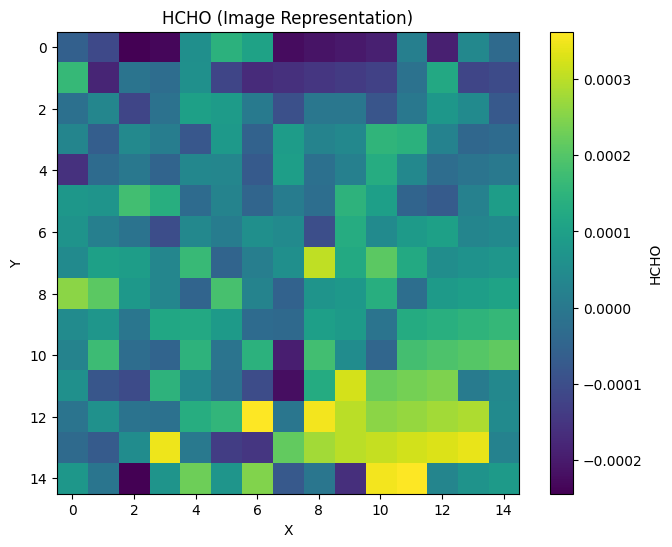

In [157]:
plot_variable_grid(df, 'HCHO')

# 👉 To be continued...
- Create UV columns base on TEMPRATURE and NDVI exemples
- Add a new columns in the dataframe based on the user settings
- create a fonction to export plot in png
- create the API to send the images to the website from position of the user current range in the map
- create request in the website to get the data from the API
- Deploy the API on Scalingo